# FINM 367 - TA Review Session 8
Tobias Rodriguez del Pozo

tobiasdelpozo@uchicago.edu

Agenda for today:
1. Risk Decomposition (AKA. feature engineering)
2. Carry Trade
3. Python Fun(?)

## 1. Risk Decomposition

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys 

sys.path.append('../cmds/')
import TA_utils as ta 


plt.style.use('ggplot')

# Read ltcm_exhibits_data.xlsx and get sheet Exhibit 2
ltcm = pd.read_excel('../data/ltcm_exhibits_data.xlsx', sheet_name='Exhibit 2', skiprows=2, index_col=0, parse_dates=[0]).iloc[:-4, :]
ltcm.index.name = 'Date'

# Get SPY returns from returns (total) in gmo_analysis_data.xlsx
spy = pd.read_excel('../data/gmo_analysis_data.xlsx', sheet_name='returns (total)', index_col=0, parse_dates=[0])[['SPY']]
us3m = pd.read_excel('../data/gmo_analysis_data.xlsx', sheet_name='risk-free rate', index_col=0, parse_dates=[0])[['US3M']]

# Make index a dateindex not a timestamp for ltcm
ltcm.index = pd.to_datetime(ltcm.index, format='%Y-%m-%d') + pd.tseries.offsets.MonthEnd(0)

ltcm = ltcm[['Net Monthly Performanceb']].dropna()
ltcm = ltcm.rename(columns={'Net Monthly Performanceb': 'LTCM'})

# Join on month and year of the index
df = ltcm.join(spy, how='inner').join(us3m, how='inner')

What are we actually doing in HW8? 

What we're trying to do is to test the sensitivity of a portfolio to different risk factors. So, as a toy example:

Text(0.5, 0, 'SPY')

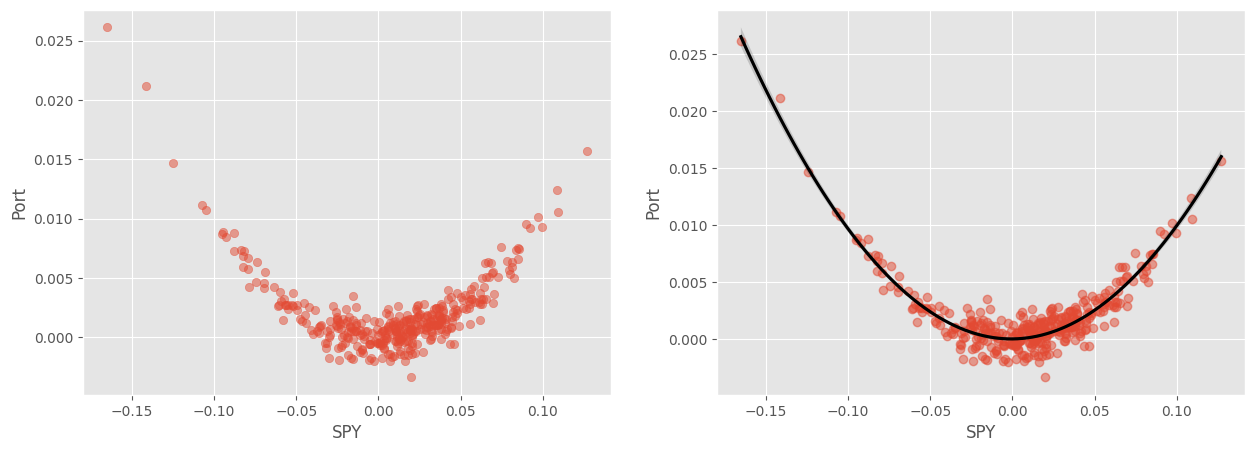

In [179]:
# Make our portfolio follow the -market^2 when market is down, and market when market is up
ex = spy.copy()
ex['Port'] = spy ** 2
# Add noise
ex['Port'] = ex['Port'] + np.random.normal(0, 0.001, size=len(ex))

# Make 2x1 subplots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(ex['SPY'], ex['Port'], alpha=0.5)

# Take fit linear regression (quadratic)
sns.regplot(x='SPY', y='Port', data=ex, ax=axes[1], order=2, scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})

axes[0].set_ylabel('Port')
axes[0].set_xlabel('SPY')

<AxesSubplot:xlabel='SPY', ylabel='Straddle'>

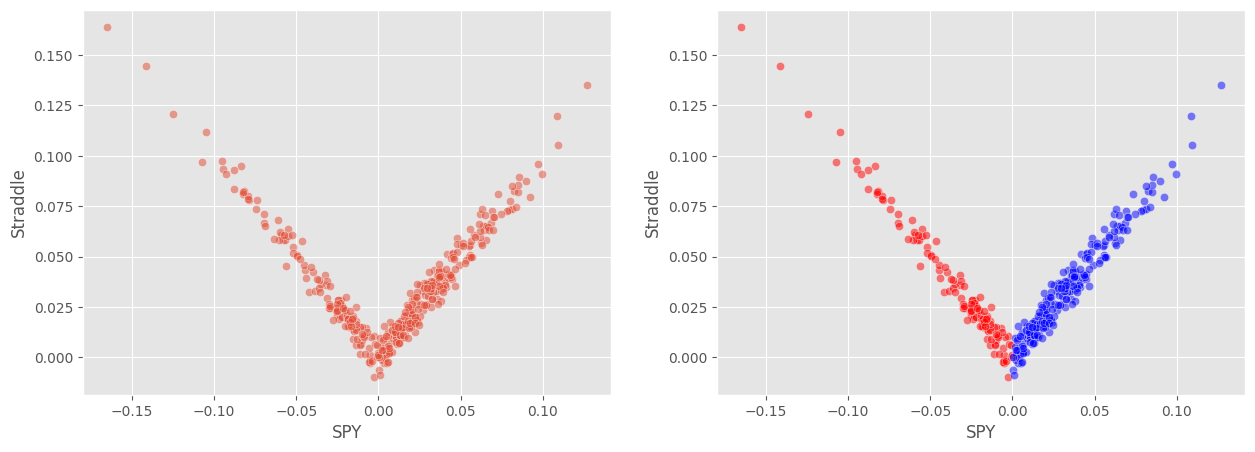

In [161]:
# That was pretty easy, but what if our payoff function is more complicated? Let's
# say we're long a straddle at 0.00 returns (ie. ATM). 

ex['Straddle'] = np.abs(spy)
ex['Straddle'] = ex['Straddle'] + np.random.normal(0, 0.005, size=len(ex))

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.scatterplot(x='SPY', y='Straddle', data=ex, alpha=0.5, ax=axes[0])

# Then we can decompose the payoff into a linear combination of basis functions.
# Plot where spy < 0 red and spy > 0 blue
sns.scatterplot(x='SPY', y='Straddle', data=ex[ex['SPY'] < 0], alpha=0.5, ax=axes[1], color='red')
sns.scatterplot(x='SPY', y='Straddle', data=ex[ex['SPY'] > 0], alpha=0.5, ax=axes[1], color='blue')

In [162]:
# We can fit a linear model to this data, by dividing it into a "put like" factor, and a "call like" factor
ex['Put'] = ex['SPY'].copy()
ex['Put'][ex['SPY'] > 0] = 0
ex['Put'] = np.abs(ex['Put'])
ex['Call'] = ex['SPY'].copy()
ex['Call'][ex['SPY'] < 0] = 0
ex['Call'] = np.abs(ex['Call'])

# Fit linear regression
model = sm.OLS(ex['Straddle'], ex[['Put', 'Call', 'SPY']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Straddle   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.371e+04
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        10:48:49   Log-Likelihood:                          1425.1
No. Observations:                 369   AIC:                                     -2846.
Df Residuals:                     367   BIC:                                     -2838.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Put            1.0041      0.007    148.689      0.000       0.991       1.017
Call           1.0029      0.006    162.825      0.000       0.991       1.015
SPY           -0.0012      0.004     -0.299      0.765      -0.009       0.007
==============================================================================
Omnibus:                        4.189   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.033
Skew:                           0.061   Prob(JB):                        0.219
Kurtosis:                       2.573   Cond. No.                     5.19e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is  4e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

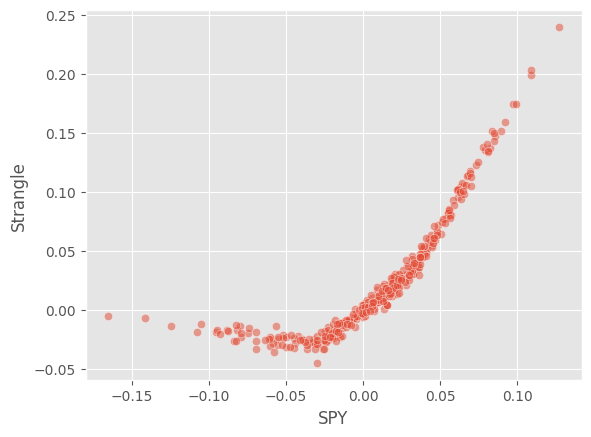

In [163]:
# Actually, suppose we are long a strangle at -0.03 and 0.03 returns (ie. OTM). 
# And, we are also long SPY.
ex['Strangle'] = np.maximum(spy - 0.03, 0) + np.maximum(-0.03 - spy, 0) + spy + spy**2
ex['Strangle'] = ex['Strangle'] + np.random.normal(0, 0.005, size=len(ex))

sns.scatterplot(x='SPY', y='Strangle', data=ex, alpha=0.5);

In [164]:
# And now linearly decompose the payoff into a linear combination of basis functions.
ex['STG_Put'] = np.maximum(-0.03 - spy, 0)
ex['STG_Call'] = np.maximum(spy - 0.03, 0)
ex['STG_Spy'] = spy
ex['STG_Spy2'] = spy**2

# Fit linear regression
model = sm.OLS(ex['Strangle'], ex[['STG_Put', 'STG_Call', 'STG_Spy', 'STG_Spy2']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Strangle   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.170e+04
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        10:48:49   Log-Likelihood:                          1458.4
No. Observations:                 369   AIC:                                     -2909.
Df Residuals:                     365   BIC:                                     -2893.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STG_Put        1.0856      0.069     15.772      0.000       0.950       1.221
STG_Call       1.0567      0.054     19.657      0.000       0.951       1.162
STG_Spy        0.9908      0.014     71.453      0.000       0.964       1.018
STG_Spy2       0.5594      0.388      1.444      0.150      -0.203       1.321
==============================================================================
Omnibus:                        2.236   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.327   Jarque-Bera (JB):                1.982
Skew:                          -0.133   Prob(JB):                        0.371
Kurtosis:                       3.240   Cond. No.                         75.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

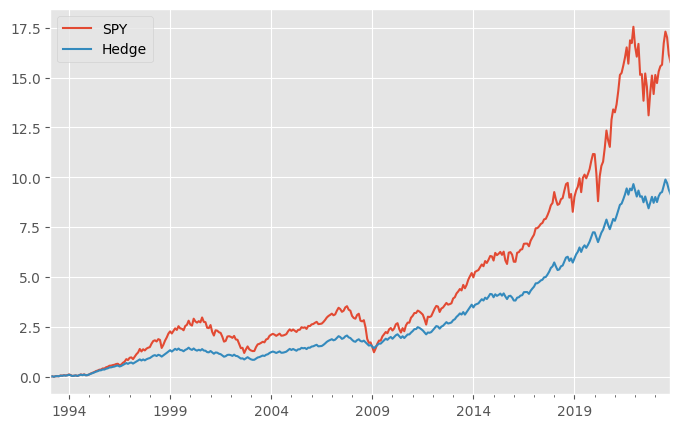

In [165]:
# One potential application is so-called "downside protection" or "PnL smoothing". This is very popular in hedge funds and 
# other asset managers. The idea is that you want to protect your portfolio from large losses, but you don't want to give up
# too much upside.

# So, you buy a put option. The problem with this is that it might be expensive to buy a put option.
# Why don't we give up some upside to pay for the put option and make it cheaper? We do this by selling a call option.

# Eg. Put options might cost $10, and call options might cost $5. So we enter into long put, short call position, and pay $5.
# this lets us buy *double* the number of put options. Also, note that selling a call also somewhat helps our downside protection,
# since we are short more deltas!

# Let's see how this works in practice. Let's say we are long SPY, and we want to protect against a 10% drop in SPY.
ex['Hedge'] = spy.copy() - np.maximum(spy - 0.03, 0) + np.maximum(-0.03 - spy, 0)

# Plot cumulative returns
((1 + ex[['SPY', 'Hedge']]).cumprod() - 1).plot(figsize=(8, 5));

In [166]:
ta.calc_performance_metrics(ex[['SPY', 'Hedge']], adj=12).T

,SPY,Hedge
Annualized Return,0.103263,0.078839
Annualized Volatility,0.149049,0.079926
Annualized Sharpe Ratio,0.692811,0.986398
Annualized Sortino Ratio,0.960999,2.415734
Skewness,-0.573558,-0.477015
Excess Kurtosis,0.96465,-1.339603
VaR (0.05),-0.072096,-0.03
CVaR (0.05),-0.095617,-0.03
Min,-0.165187,-0.03
Max,0.126984,0.03


In [167]:
ta.calc_univariate_regression(ex['Hedge'], ex['SPY']).T

,Hedge
Alpha,0.028836
Beta,0.484234
Downside Beta,0.219308
R-Squared,0.815438
Treynor Ratio,0.162811
Information Ratio,0.839787
Tracking Error,0.002861


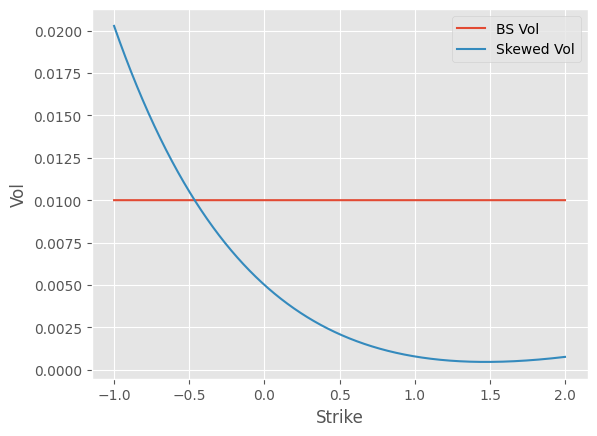

In [168]:
# Is this too good to be true? Well, yes. This is one of the reasons why the volatility surface is asymmetric!

# Plot -0.1 to 0.1 vs. constant vol of 5%
xx = np.arange(-1, 2, 0.001)
plt.plot(xx, np.full(len(xx), 0.01), label='BS Vol')
yy = (np.exp(-xx) + 0.01 * (xx + 10)**2 - 1.5)/100
plt.plot(xx, yy, label='Skewed Vol')
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Vol')
plt.show()

Some comments on volatility HW8, 2.4.

- Long *any* option is long volatility.
- What can we say about the volatility if we're long a call and short a put?
- At the same strike: Nothing! We're short a (synthetic) forward.
- At different strikes: ATM options will (normally) have higher vega than OTM options, so if the call is closer to ATM then we're long volatility.

What is the point of this HW? We're trying to engineer features to better explain the returns of the portfolio. This is generally very useful, because it allows us to understand the risks of the portfolio, and then hedge them accordingly, or, "load up" on them synthetically.

![](https://pbs.twimg.com/media/F_IIOc-W4AA49Ff?format=jpg&name=900x900)

## 2. Carry Trade

What is the idea?

- Borrow in low interest rate currencies
- Invest in high interest rate currencies
- Profit!

What does interest rate parity say?

- That this isn't an arbitrage

Uncovered Interest Parity (UIP) says that:
- The expected return of the carry trade is zero
- Any difference in interest rates is offset by the expected depreciation of the high interest rate currency

Eg.

- Borrow in USD at 1%
- Invest in EUR at 3%
- Expected profit is 2%
- Expected depreciation of EUR is 2%
- Expected return is 0%

Note that this generally doesn't hold in practice.

Covered Interest Parity (CIP) is truly a no-arbitrage condition. It says that:
- The FORWARD exchange rate should be equal to the SPOT exchange rate, adjusted for the interest rate differential
- Thus, you are unable to "lock-in" a profit by borrowing in one currency and investing in another

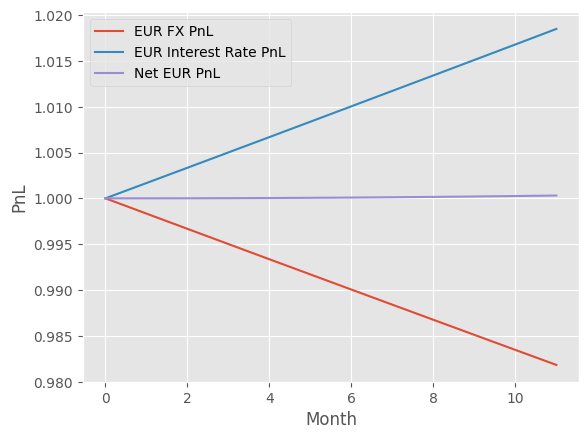

In [169]:
# Plot an example of carry trade.
# Make EUR depreciate by 2/12 per month
eur = pd.DataFrame(np.ones(12)).T.iloc[0]
for i in range(1, 12):
    eur[i] = eur[i-1] * (1 - 0.02/12)
    
usd = pd.DataFrame(np.ones(12)).T.iloc[0]

# Make interest rate series for EUR
eur_ir = pd.DataFrame(np.ones(12)).T.iloc[0]
for i in range(1, 12):
    eur_ir[i] = eur_ir[i-1] * (1 + 0.02/12)
    
# Plot EUR
plt.plot(eur, label='EUR FX PnL')
plt.plot(eur_ir, label='EUR Interest Rate PnL')
plt.plot(eur_ir + eur - 1, label='Net EUR PnL')
plt.legend()
plt.xlabel('Month')
plt.ylabel('PnL')
plt.show()

What I would recommend for these questions is that the **most** important thing is setting up your data correctly. If you do that, then the rest is just a matter of applying the formulas and running the regressions, eg. see HW8 solutions from last year.

## 3. Python Fun(?)

In [170]:
# Here is another example of dictionary unpacking and where it can be useful.
# Recall from the calc_iterative_regression(y, X, intercept=True, one_to_many=False, adj=12) function,
# that we have 3 different parameters that we can set. Suppose that for *this* notebook in
# particular, we want to change all of them. However, we don't want to have to repeatedly call
# the function with different parameters, eg:

etfs = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name="excess returns", index_col=0, parse_dates=[0])

ta.calc_iterative_regression(
    etfs[["IEF", "HYG", "PSP"]], etfs[["SPY"]], intercept=False, one_to_many=True, adj=52
)

# We can simply make a dictionary of the parameters we want to change, and then unpack it into
# the function.

PARAMS = {"intercept": False, "one_to_many": True, "adj": 52}

ta.calc_iterative_regression(etfs[["IEF", "HYG", "PSP"]], etfs[["SPY"]], **PARAMS)

# We can also use something like functools.partial to *partially* apply the function with the
# parameters we want to change. This is useful if we want to change multiple parameters, perhaps
# in a more complex way, or by personal preference. This pre-applies the parameters we want to change,
# and returns a new function that we can call with the remaining parameters.

from functools import partial

ta.calc_iterative_regression_partial = partial(
    ta.calc_iterative_regression, intercept=False, one_to_many=True, adj=12
)

ta.calc_iterative_regression_partial(etfs[["IEF", "HYG", "PSP"]], etfs[["SPY"]])

# When is functools.partial particularly useful? Think about how many times we've had to load in
# an excel sheet and parse the dates.

read_excel = partial(pd.read_excel, "../data/multi_asset_etf_data.xlsx", index_col=0, parse_dates=[0])
etfs = read_excel(sheet_name="excess returns")

# Finally, note how we're constantly repeating etfs[["IEF", "HYG", "PSP"]] and etfs["SPY"] in the
# function calls! We could fix this with another partial function, but we can also use list unpacking.
VAR_LIST = [etfs[["IEF", "HYG", "PSP"]], etfs[["SPY"]]]

# This is what Python means when you see a function that looks like: func(*args, **kwargs)
# Note how we can end the line with a ';' to suppress the output of the function call.
ta.calc_iterative_regression(*VAR_LIST, **PARAMS);

In [171]:
# Use of list slicing also applies to strings, and DataFrames!
# Think about why this might be the case. What is the general concept
# that allows us to both loop through something and also slice it?

my_list = [i for i in range(10)]

# Get the first 5 elements
my_list[:5]

# Get last 5 elements
my_list[-5:]

# Get the middle 5 elements
my_list[2:7]

# Get every second element
my_list[::2]

# Get every second element starting from 3
my_list[3::2]

# Reverse the list
my_list[::-1]

# Get the first 5 elements, but in reverse
my_list[4::-1]

# Note how this works for DataFrames as well!
my_df = pd.DataFrame(np.random.randn(10, 5), columns=[f"Col {i}" for i in range(5)])

# Same as with the df
my_df.iloc[:5]
my_df.iloc[-5:]
my_df.iloc[2:7]
my_df.iloc[::2]
my_df.iloc[3::2]
my_df.iloc[::-1]
my_df.iloc[4::-1]

# etc.

my_list.__getitem__(slice(0, 5, 1))
my_df.__getitem__(slice(0, 5, 1));


In [180]:
# Let's say I'm fed up of not being able to slice my dictionary, after all,
# who uses integers as keys anyway? I want to be able to do something like:

d = {"a": 1, "b": 2, "c": 3}
d[0:2]

# :(

TypeError: unhashable type: 'slice'

In [173]:
class SliceyDict(dict):
    def __getitem__(self, key):
        if isinstance(key, slice):
            if isinstance(key.start, int):
                return {k: self[k] for k in list(self.keys())[key]}
            elif isinstance(key.start, str):
                return {k: self[k] for k in list(self.keys())[list(self.keys()).index(key.start):list(self.keys()).index(key.stop) + 1]}
        else:
            return super().__getitem__(key)
        
d = SliceyDict({"a": 1, "b": 2, "c": 3})
display(d[0:2])
display(d["a":"c"])

{'a': 1, 'b': 2}

{'a': 1, 'b': 2, 'c': 3}

In [174]:
# Why might this be a bad idea?
# Hint: https://github.com/python/cpython/blob/main/Objects/dictobject.c
# What is the extension of this file?

In [175]:
# Also
for i in range(10):
    ...
    
for i in range(10):
    pass

In [176]:
type(...)

ellipsis

In [ ]:
# 3 characters vs. 4?